## Import necessary python libraries

In [1]:
import feyn
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
import warnings
warnings.filterwarnings('ignore')
import collections
import os

In [68]:
from functions import *

In [3]:
feyn.__version__

'2.1.2'

In [42]:
projectname = 'insulin_response_'
pathname = '../figures/'

## Load necessary files

In [38]:
expression_table = '../data/insulin_dataset.csv'
data_togo = pd.read_csv(expression_table, sep=',')

In [5]:
data_togo.head()

,Cond,7SK,A1BG,A2M,A2M-AS1,A4GALT,AAAS,AACS,AADAC,AADAT,...,ZYX,ZZEF1,ZZZ3,hsa-mir-1199,hsa-mir-3180-3,hsa-mir-3180-4,hsa-mir-6080,hsa-mir-8072,Class_,CV_Split
0,NG1f0,61.707,0.869,22.325312,5.504,1.3035,26.7975,6.373,77.641,1.3035,...,14.70225,27.232,11.0085,1.5930,1.4490,0.869,1.738,2.028,0.0,0.0
1,NG1h0,67.008,1.600,29.549125,4.621,2.7550,22.2175,43.013,57.232,3.7325,...,17.32925,29.149,13.0635,2.0440,2.0440,0.711,0.889,2.488,1.0,0.0
2,NG2f0,37.882,3.164,20.439625,7.035,23.3330,28.9115,19.316,51.453,1.7900,...,41.75375,57.489,10.6155,6.6395,11.3650,7.576,1.499,1.957,0.0,1.0
3,NG2h0,75.477,2.901,16.411500,6.017,24.4965,30.2445,20.091,62.101,1.4775,...,25.87975,58.394,11.2005,5.6140,8.5955,4.029,1.558,1.826,1.0,1.0
4,NG3f0,131.061,8.107,13.412812,16.214,43.6870,28.3740,3.828,0.000,1.0135,...,60.01325,47.515,4.5040,6.3055,3.7155,1.126,0.901,3.828,0.0,2.0


In [6]:
# make dictionary to store original features names
features_dict = dict()
for genes_names in data_togo.columns:
    qlattice_gene_names = genes_names.replace(".", "_").replace(".", "_")
    features_dict[qlattice_gene_names] = genes_names

## Standardise feature names

In [7]:
data_togo.columns = data_togo.columns.str.replace(".", "_")
data_togo.columns = data_togo.columns.str.replace("-", "_")

In [8]:
data_togo

,Cond,7SK,A1BG,A2M,A2M_AS1,A4GALT,AAAS,AACS,AADAC,AADAT,...,ZYX,ZZEF1,ZZZ3,hsa_mir_1199,hsa_mir_3180_3,hsa_mir_3180_4,hsa_mir_6080,hsa_mir_8072,Class_,CV_Split
0,NG1f0,61.707,0.869,22.325312,5.504,1.3035,26.7975,6.373,77.641,1.3035,...,14.70225,27.232,11.0085,1.5930,1.4490,0.869,1.738,2.028,0.0,0.0
1,NG1h0,67.008,1.600,29.549125,4.621,2.7550,22.2175,43.013,57.232,3.7325,...,17.32925,29.149,13.0635,2.0440,2.0440,0.711,0.889,2.488,1.0,0.0
2,NG2f0,37.882,3.164,20.439625,7.035,23.3330,28.9115,19.316,51.453,1.7900,...,41.75375,57.489,10.6155,6.6395,11.3650,7.576,1.499,1.957,0.0,1.0
3,NG2h0,75.477,2.901,16.411500,6.017,24.4965,30.2445,20.091,62.101,1.4775,...,25.87975,58.394,11.2005,5.6140,8.5955,4.029,1.558,1.826,1.0,1.0
4,NG3f0,131.061,8.107,13.412812,16.214,43.6870,28.3740,3.828,0.000,1.0135,...,60.01325,47.515,4.5040,6.3055,3.7155,1.126,0.901,3.828,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,NO77h2,81.744,3.071,19.550250,11.340,3.6620,25.5155,26.933,106.787,2.2445,...,19.13675,35.674,12.2855,2.5990,1.7720,0.236,0.473,1.890,1.0,4.0
134,NO89f0,75.857,2.423,8.565000,6.664,47.7895,28.3035,4.981,6.664,0.9090,...,43.80125,65.761,4.6440,7.2695,3.5675,1.750,1.010,4.981,0.0,0.0
135,NO89f2,308.708,2.424,21.948313,2.277,6.9425,33.7580,5.877,74.349,2.0940,...,26.08100,25.934,10.1385,3.1590,1.4695,1.102,0.882,1.837,0.0,0.0
136,NO89h0,151.748,2.106,6.307750,7.538,56.1985,26.9635,22.668,7.039,1.8845,...,37.36900,62.462,4.3785,5.9580,4.8770,2.605,1.275,6.595,1.0,0.0


## Training a QLattice in a cross-validation scheme as framework


In [9]:
logdir='../models_insulin_paper/'
os.makedirs(logdir, exist_ok=True)


partitions_interval = np.arange(5)
inner_partitions_interval = partitions_interval#[partitions_interval != 4]

results = ModelResults()

all_fold_models = []


for val_partition in inner_partitions_interval:
    os.makedirs('%spartition_%i' % (logdir, val_partition), exist_ok=True)
    model_file = "%spartition_%i/model" % (logdir, val_partition)
    train = data_togo.loc[(data_togo.CV_Split != val_partition)]
    val = data_togo.loc[(data_togo.CV_Split == val_partition)]
    
    # Connecting to the QLattice
    
    ql = feyn.connect_qlattice()

    # Setting a seed
    
    ql.reset(random_seed=42)  

    stypes = dict()
    for f in train.columns:
        if train[f].dtype =='object':
            stypes[f] = 'c'
            
    models_ = ql.auto_run(data=train,
                          output_name="Class_",
                          kind="classification",
                          n_epochs=50,
                          max_complexity=5,
                          stypes=stypes,
                          criterion="bic",
                 )
    
    all_fold_models.append(models_)
    
    for j in models_:
        results.update(train, val, val_partition, j)
    
    for i in range(len(models_)):    
        models_[i].save(model_file+'_'+str(val_partition)+'_'+str(i)+'.json')
        
    

In [67]:
np.mean(results.df.groupby("fold").first().roc_auc_val), np.mean(results.df.roc_auc_val)

(0.9397024245595673, 0.9511417971527862)

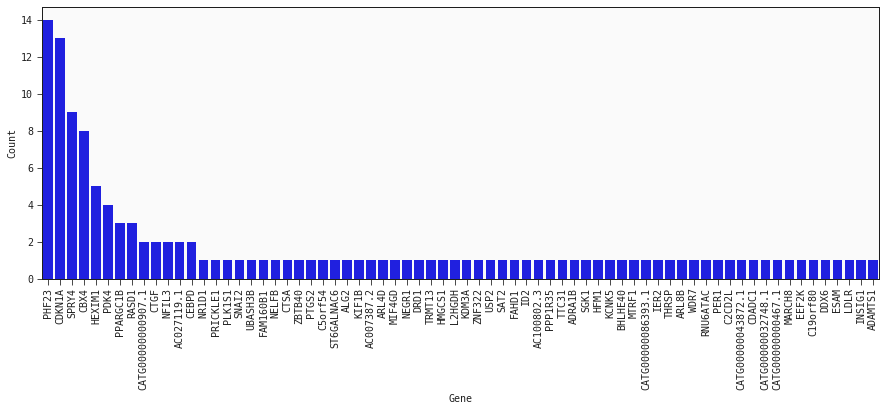

In [85]:
feat_list = list()
for j in range(5):
    for i in range(len(all_fold_models[j])):
        genes = all_fold_models[j][i].features
        for gene in genes:
            if gene in features_dict.keys():
                feat_list.append(features_dict[gene])
            
count_features = collections.Counter(feat_list)
count_features_df = pd.DataFrame(count_features.items(),columns=['Gene', 'Count']).sort_values('Count', ascending=False)

plt.figure(figsize=(15, 5))
sns.barplot(x=count_features_df.Gene,y=count_features_df.Count, color='blue')
plt.xticks(rotation=90)
#plt.tight_layout()


plt.savefig(pathname+projectname+'gene_count.pdf')

In [86]:
# Assign colors to chosen features
lut = dict({0: 'w',
           1: 'b'})

# Map colors to correlation data
row_coloring = pd.Series(list(set(feat_list)), index = abs(data_togo[set(feat_list)].corr()).index).map(lut)

In [92]:
abs(data_togo[set(feat_list)].corr())

,AC027119.1,C5orf54,TRMT13,MTRF1,ADRA1B,PRICKLE1,RNU6ATAC,AC007387.2,ZNF322,KDM3A,...,CDADC1,TTC31,SNAI2,NR1D1,PLK1S1,SAT2,CATG00000032748.1,ADAMTS1,PPARGC1B,HFM1
AC027119.1,1.000000,0.391333,0.015028,0.173274,0.177708,0.206911,0.427297,0.358451,0.109502,0.253041,...,0.199820,0.248513,0.240752,0.353559,0.304332,0.121642,0.039149,0.525515,0.275254,0.088199
C5orf54,0.391333,1.000000,0.527226,0.484835,0.217980,0.057848,0.168880,0.134048,0.543454,0.649327,...,0.339077,0.464881,0.128788,0.500387,0.125152,0.398457,0.136594,0.186529,0.361077,0.063475
TRMT13,0.015028,0.527226,1.000000,0.434912,0.006738,0.283105,0.280031,0.190281,0.570752,0.570898,...,0.091294,0.502306,0.322007,0.338897,0.205698,0.178498,0.167991,0.055824,0.135841,0.076670
MTRF1,0.173274,0.484835,0.434912,1.000000,0.126474,0.033529,0.001114,0.011995,0.378462,0.472166,...,0.350866,0.584905,0.288050,0.355443,0.130939,0.202413,0.127036,0.213791,0.348995,0.088417
ADRA1B,0.177708,0.217980,0.006738,0.126474,1.000000,0.156092,0.129281,0.187954,0.077387,0.160296,...,0.210081,0.124613,0.099297,0.274619,0.218584,0.440103,0.188120,0.284797,0.363052,0.323545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAT2,0.121642,0.398457,0.178498,0.202413,0.440103,0.045513,0.052410,0.011371,0.228612,0.258519,...,0.325732,0.106571,0.028148,0.121191,0.150506,1.000000,0.089716,0.103240,0.240511,0.042174
CATG00000032748.1,0.039149,0.136594,0.167991,0.127036,0.188120,0.024615,0.155933,0.198922,0.036842,0.258558,...,0.207413,0.161581,0.027628,0.044007,0.291491,0.089716,1.000000,0.095799,0.014684,0.010418
ADAMTS1,0.525515,0.186529,0.055824,0.213791,0.284797,0.430348,0.243803,0.291253,0.123580,0.014305,...,0.162443,0.209626,0.306197,0.346477,0.548774,0.103240,0.095799,1.000000,0.415748,0.227403
PPARGC1B,0.275254,0.361077,0.135841,0.348995,0.363052,0.500089,0.462669,0.473467,0.017066,0.340506,...,0.058115,0.302466,0.167243,0.615856,0.103563,0.240511,0.014684,0.415748,1.000000,0.172600


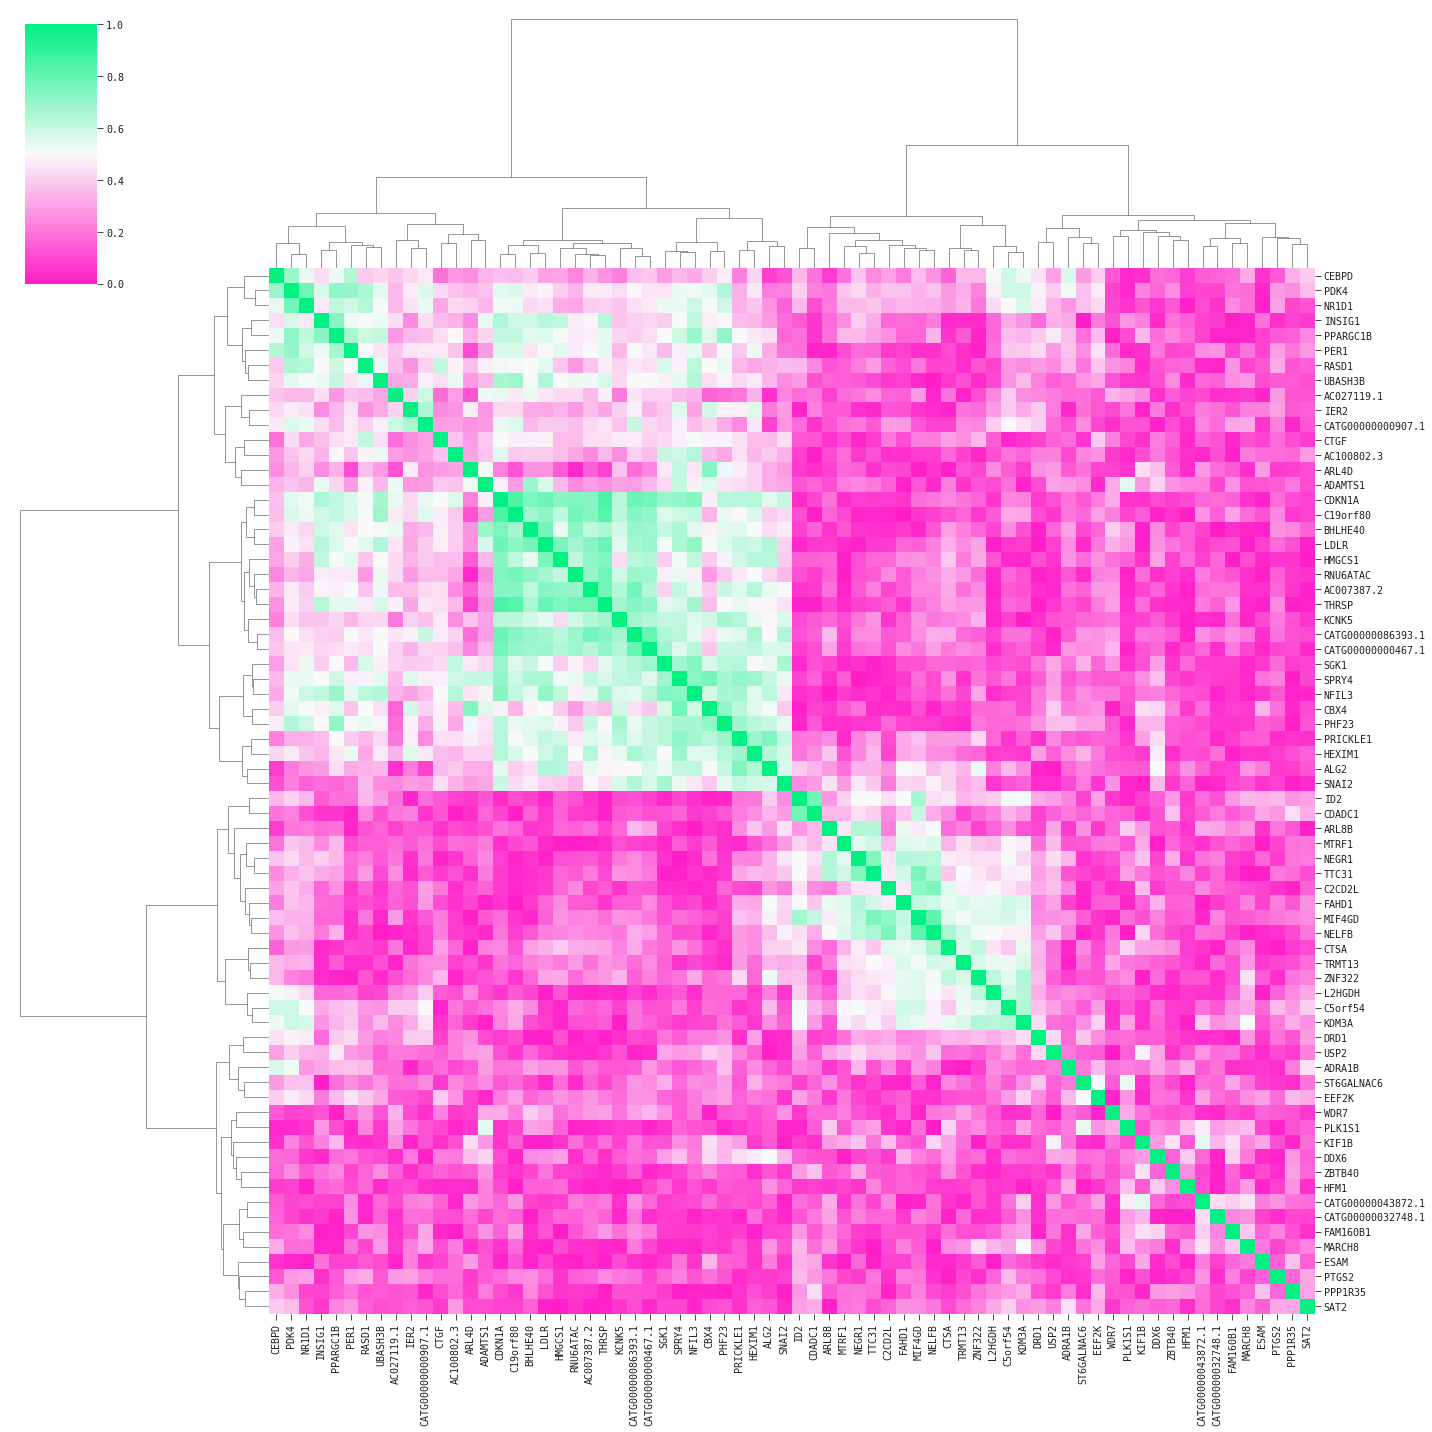

In [94]:
p = sns.clustermap(abs(data_togo[set(feat_list)].corr()), method="ward", cmap='feyn-diverging', #row_colors = row_coloring,
               vmin=0, vmax=1, figsize=(20,20), robust=False)
p.savefig(pathname+projectname+"clustermap.pdf")

## Training a QLattice in train-test split mode for final model choice



In [70]:
logdir='../models_insulin_paper_train_test/'
os.makedirs(logdir, exist_ok=True)

results_train_test = ModelResults()
os.makedirs('%spartition_%i' % (logdir, 1), exist_ok=True)
model_file = "%spartition_%i/model" % (logdir, 1)
train = data_togo.loc[(data_togo.CV_Split != 1)]
test = data_togo.loc[(data_togo.CV_Split == 1)]

# Connecting to the QLattice

ql = feyn.connect_qlattice()

# Setting a seed

ql.reset(random_seed=42)  

stypes = dict()
for f in train.columns:
    if train[f].dtype =='object':
        stypes[f] = 'c'

models_ = ql.auto_run(data=train,
                      output_name="Class_",
                      kind="classification",
                      n_epochs=50,
                      max_complexity=5,
                      stypes=stypes,
                      criterion="bic",
             )

for j in models_:
    results_train_test.update(train, test, 1, j)

for i in range(len(models_)):    
    models_[i].save(model_file+'_'+str(1)+'_'+str(i)+'.json')

In [71]:
df_summary = modsum(models_, train, test)[['N. Features', 'Functional form', 'BIC', 'Loss', 'AUC Train']]
df_summary

,N. Features,Functional form,BIC,Loss,AUC Train
0,3,logreg(PHF23 + PPP1R35 + RNU6ATAC),19.58,0.045276,1.0
1,3,logreg(C2CD2L + PDK4 + PHF23),20.79,0.050682,1.0
2,3,logreg(CATG00000043872.1*CDADC1 + SPRY4),20.81,0.029703,1.0
3,3,logreg(AC027119.1 + CATG00000032748.1 + PHF23),28.02,0.082960,1.0
4,3,logreg(CATG00000000467.1 + MARCH8 + PHF23),34.91,0.113712,0.99
5,2,logreg(SPRY4 + 1/EEF2K),36.47,0.120684,0.99
6,3,logreg(ERVK13-1 + PHF23 + SPRY4),36.51,0.120844,0.99
7,3,logreg(C19orf80 + CEBPD + DDX6),37.29,0.124340,0.99
8,3,logreg(CBX4 + ESAM + LDLR),38.09,0.127931,0.99
9,3,logreg(CDKN1A + CTB-55O6.10 + ID2),38.27,0.128724,0.99


In [72]:
print(df_summary.to_latex())

\begin{tabular}{lrllrl}
\toprule
{} &  N. Features &                                 Functional form &    BIC &      Loss & AUC Train \\
\midrule
0 &            3 &              logreg(PHF23 + PPP1R35 + RNU6ATAC) &  19.58 &  0.045276 &       1.0 \\
1 &            3 &                   logreg(C2CD2L + PDK4 + PHF23) &  20.79 &  0.050682 &       1.0 \\
2 &            3 &        logreg(CATG00000043872.1*CDADC1 + SPRY4) &  20.81 &  0.029703 &       1.0 \\
3 &            3 &  logreg(AC027119.1 + CATG00000032748.1 + PHF23) &  28.02 &  0.082960 &       1.0 \\
4 &            3 &      logreg(CATG00000000467.1 + MARCH8 + PHF23) &  34.91 &  0.113712 &      0.99 \\
5 &            2 &                         logreg(SPRY4 + 1/EEF2K) &  36.47 &  0.120684 &      0.99 \\
6 &            3 &                logreg(ERVK13-1 + PHF23 + SPRY4) &  36.51 &  0.120844 &      0.99 \\
7 &            3 &                 logreg(C19orf80 + CEBPD + DDX6) &  37.29 &  0.124340 &      0.99 \\
8 &            3 &            

In [73]:
model = models_[1]

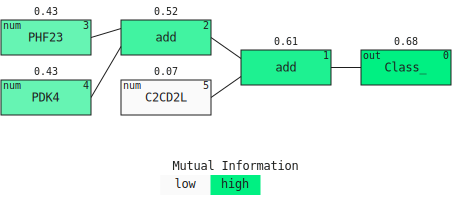

In [74]:
model.plot_signal(train, corr_func='mutual_information', 
                             filename=pathname+projectname+'plot_signal_mi.svg')

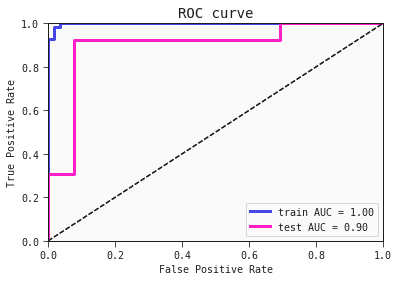

In [75]:
model.plot_roc_curve(train, label='train')
model.plot_roc_curve(test, label='test', ax=plt.gca())
plt.savefig(pathname+projectname+'roc_auc'+'.pdf', dpi=300, bbox_inches='tight')

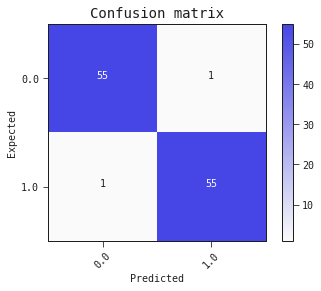

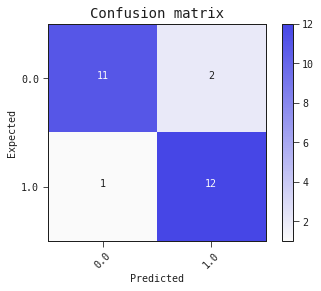

In [76]:
model.plot_confusion_matrix(train, filename=pathname+projectname+'confusion_train'+'.pdf')
model.plot_confusion_matrix(test, filename=pathname+projectname+'confusion_test'+'.pdf')

In [77]:
#results_train_test.df

In [78]:
#models_[0].plot_response_2d(test)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="232.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 741 232.0" width="741" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="50.0"><title>Class_
logistic:
w=17.3165
bias=0.7273</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">Class_</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="59.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="76.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="20.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">2</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="28.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="46.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>CATG00000043872.1
linear:
scale=0.070759
scale offset=14.837938
w=1.766193
bias=0.0167</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">CATG0000..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>CDADC1
linear:
scale=0.051211
scale offset=9.921384
w=-1.437835
bias=-1.2357</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">CDADC1</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="80.0"><title>SPRY4
linear:
scale=0.072553
scale offset=9.990009
w=4.004280
bias=0.2893</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">SPRY4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="89.0">num</text></svg><svg class="summary" height="79" width="180" x="471" y="0"><defs /><text fill="#1E1E1E" font-family=
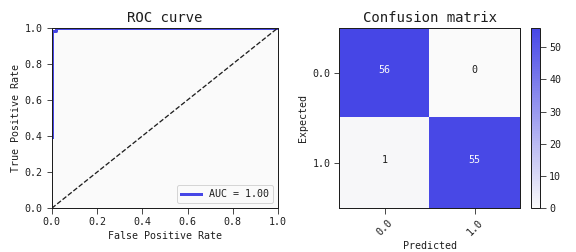
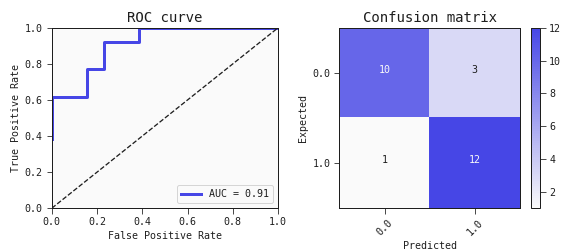

In [79]:
models_[2].plot(train,test)

In [80]:
feat_list = list()
for i in range(len(models_)):
    genes = models_[i].features
    for gene in genes:
        if gene in features_dict.keys():
            feat_list.append(features_dict[gene])

In [81]:
count_features = collections.Counter(feat_list)
count_features_df = pd.DataFrame(count_features.items(),columns=['Gene', 'Count']).sort_values('Count', ascending=False)

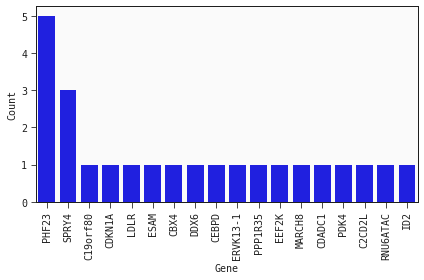

In [82]:
sns.barplot(x=count_features_df.Gene,y=count_features_df.Count, color='blue')
plt.xticks(rotation=90)
plt.tight_layout()

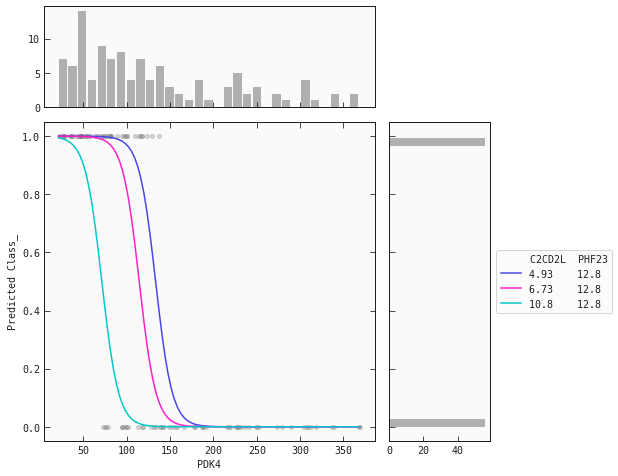

In [83]:
show_quantiles = 'C2CD2L'
fixed = {}
fixed[show_quantiles] = [
    train[show_quantiles].quantile(q=0.25),
    train[show_quantiles].quantile(q=0.5),
    train[show_quantiles].quantile(q=0.75)
]

model.plot_response_1d(train, by = 'PDK4', input_constraints=fixed, 
                            filename=pathname+projectname+'bestmodel_response1d'+'.pdf')